Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import PIL.Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import cv2
import matplotlib.pyplot as plt

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
data_dir_train

PosixPath('/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2210
118


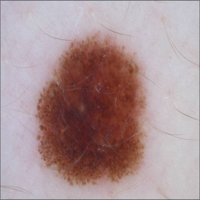

In [6]:
#checking a image from the dataset
nevus_eg = list(data_dir_train.glob('nevus/*'))
im=PIL.Image.open(str(nevus_eg[20]))
image = im.resize((200, 200))
image

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2210 files belonging to 9 classes.
Using 1768 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2210 files belonging to 9 classes.
Using 442 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data


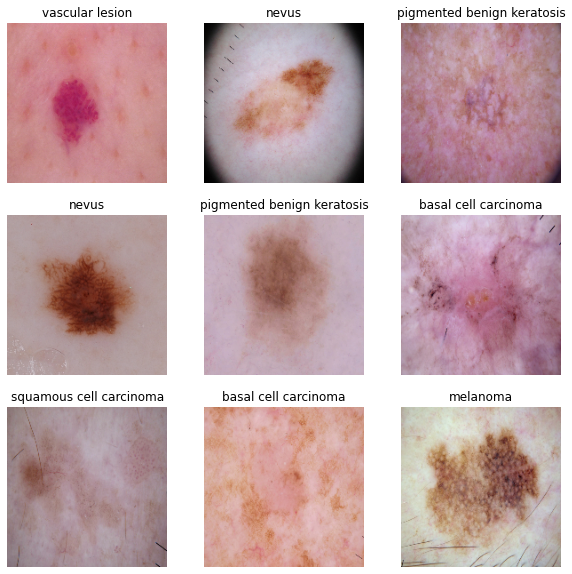

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
### Normalizing the pixels
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(
    scale=1./255,input_shape=(img_height, img_width, 3))


In [15]:
num_classes = len(class_names)

### Model 1

In [16]:

model = Sequential([
  normalization_layer,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [17]:
### choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [19]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 691s 11s/step - loss: 2.1924 - accuracy: 0.2245 - val_loss: 1.9761 - val_accuracy: 0.3348
Epoch 2/20
56/56 [==============================] - 1s 26ms/step - loss: 1.8220 - accuracy: 0.3331 - val_loss: 1.6275 - val_accuracy: 0.4186
Epoch 3/20
56/56 [==============================] - 1s 25ms/step - loss: 1.5343 - accuracy: 0.4564 - val_loss: 1.4485 - val_accuracy: 0.5000
Epoch 4/20
56/56 [==============================] - 1s 25ms/step - loss: 1.3742 - accuracy: 0.5266 - val_loss: 1.4568 - val_accuracy: 0.5000
Epoch 5/20
56/56 [==============================] - 1s 25ms/step - loss: 1.3323 - accuracy: 0.5368 - val_loss: 1.5003 - val_accuracy: 0.4932
Epoch 6/20
56/56 [==============================] - 1s 25ms/step - loss: 1.2892 - accuracy: 0.5509 - val_loss: 1.3852 - val_accuracy: 0.5023
Epoch 7/20
56/56 [==============================] - 1s 25ms/step - loss: 1.1929 - accuracy: 0.5877 - val_loss: 1.4776 - val_accuracy: 0.5271
Epoch 8/20
5

### Visualizing training results

In [20]:
def visualize_training_results():
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

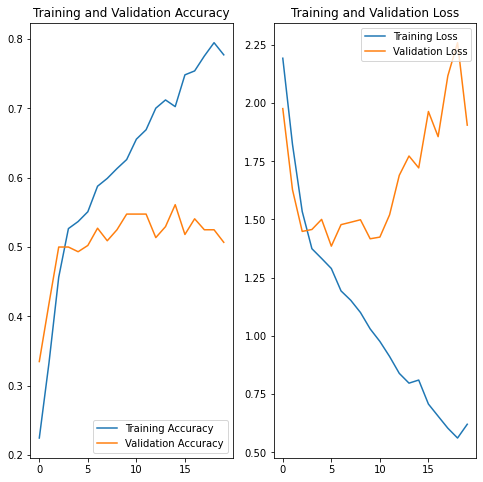

In [21]:
visualize_training_results()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
## Findings-
Training loss: 0.6202

Training accuracy: 0.7771

val_loss: 1.9050 

val_accuracy: 0.5068

We see that after 20 passes the  training accuracy is increasing linearly but validation accuracy is hovering around 50% only, so there is clearly overfitting in the data. 

In [22]:
# after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
  ]
)

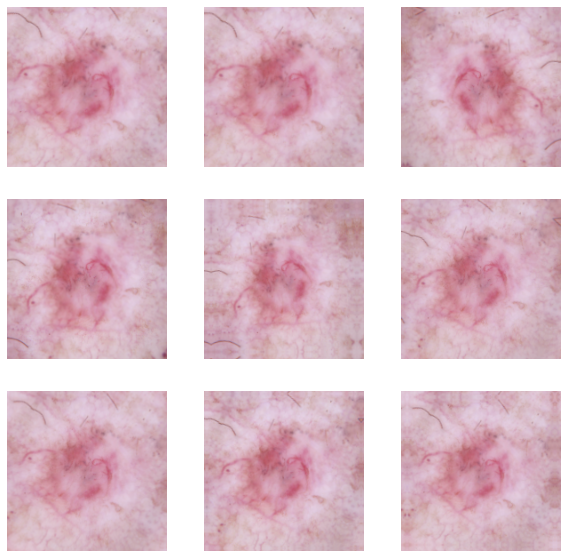

In [23]:
#visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


### Create the model, compile and train the model


## Model 2

In [24]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([
  data_augmentation,
  normalization_layer,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compiling the model

In [25]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Training the model

In [27]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 3s 33ms/step - loss: 1.9356 - accuracy: 0.2862 - val_loss: 1.7370 - val_accuracy: 0.4186
Epoch 2/20
56/56 [==============================] - 2s 29ms/step - loss: 1.6715 - accuracy: 0.4095 - val_loss: 1.5717 - val_accuracy: 0.4502
Epoch 3/20
56/56 [==============================] - 2s 29ms/step - loss: 1.5384 - accuracy: 0.4531 - val_loss: 1.7436 - val_accuracy: 0.3733
Epoch 4/20
56/56 [==============================] - 2s 29ms/step - loss: 1.4146 - accuracy: 0.4893 - val_loss: 1.5131 - val_accuracy: 0.4955
Epoch 5/20
56/56 [==============================] - 2s 29ms/step - loss: 1.3259 - accuracy: 0.5238 - val_loss: 1.4949 - val_accuracy: 0.4864
Epoch 6/20
56/56 [==============================] - 2s 29ms/step - loss: 1.3311 - accuracy: 0.5170 - val_loss: 1.4040 - val_accuracy: 0.5181
Epoch 7/20
56/56 [==============================] - 2s 29ms/step - loss: 1.2720 - accuracy: 0.5407 - val_loss: 1.4141 - val_accuracy: 0.5317
Epoch 8/20
56

### Visualizing the results

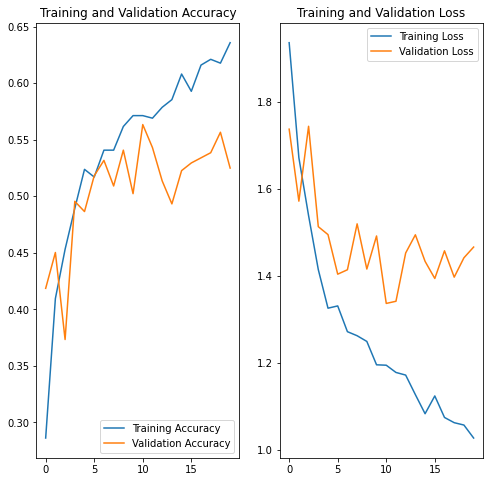

In [28]:
visualize_training_results()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

## Findings:
Training loss: 1.0277

Training accuracy: 0.6357

val_loss: 1.4663

val_accuracy: 0.5249

We see that we have removed  the overfitting from our model , but the model can be improved as the accuracy is very low and is slightly underfitting
The model is very simple right now and hence not able to identify the patterns , so we will make more changes to our models

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Figure size 720x720 with 0 Axes>

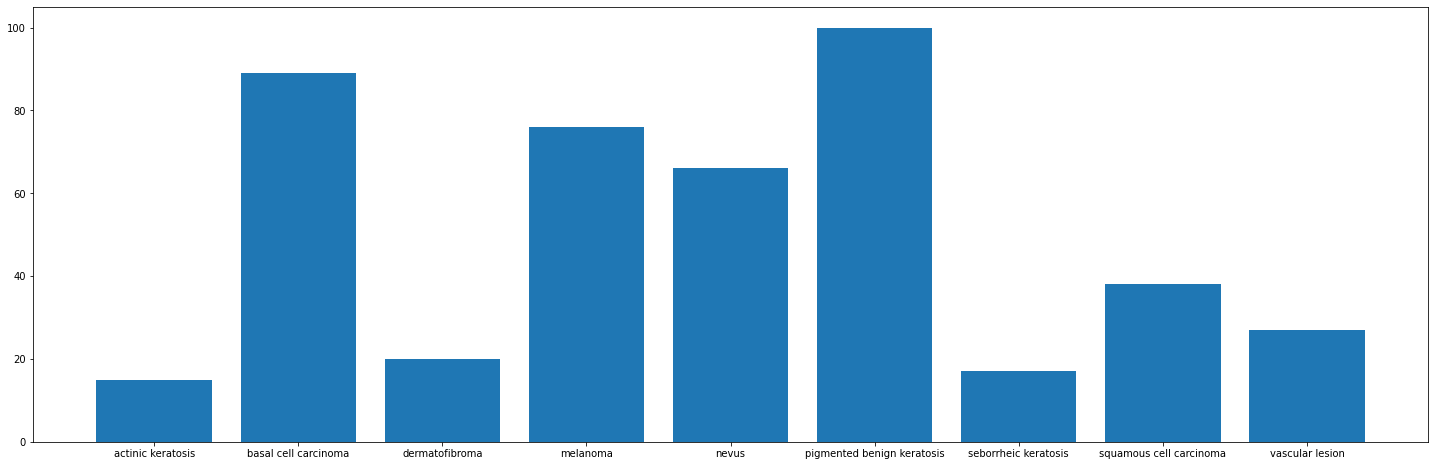

In [30]:
## Your code goes here.
import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(8):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i]) 

f = plt.figure(figsize=(25,8))

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

#### Write your findings here: 
#### - Which class has the least number of samples?
seborrheic keratosis has the least number of samples
#### - Which classes dominate the data in terms proportionate number of samples?
pigmented benign Keratosis has the highest number of samples closely followed by melanoma

####  Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [31]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [32]:
path_to_training_dataset='/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F635E1D9590>: 100%|██████████| 500/500 [00:25<00:00, 19.66 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F635E157390>: 100%|██████████| 500/500 [00:23<00:00, 21.28 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F635E157DD0>: 100%|██████████| 500/500 [00:25<00:00, 19.82 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F635E07DFD0>: 100%|██████████| 500/500 [01:42<00:00,  4.89 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F635E1A1F50>: 100%|██████████| 500/500 [01:35<00:00,  5.24 Samples/s]


Initialised with 463 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F635E07DD90>: 100%|██████████| 500/500 [00:21<00:00, 23.03 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F6360546A90>: 100%|██████████| 500/500 [00:47<00:00, 10.62 Samples/s]


Initialised with 182 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F635E1CCDD0>: 100%|██████████| 500/500 [00:21<00:00, 23.56 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F635E05D910>: 100%|██████████| 500/500 [00:21<00:00, 23.68 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [33]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [34]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list[:5]


['/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025425.jpg_01f95d07-f85a-4ce5-bed5-391a20862a93.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026068.jpg_48a873d5-640c-41e1-975f-30e101da1e1d.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025249.jpg_4cb10437-b288-4dae-ae8d-57802501a525.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0034214.jpg_cda70073-5b56-4afe-9615-2708f0adaed5.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/ou

In [35]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[495:510]

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

In [36]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [37]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])


In [38]:
df2['Label'].value_counts()

vascular lesion               500
actinic keratosis             500
nevus                         500
seborrheic keratosis          500
melanoma                      500
dermatofibroma                500
basal cell carcinoma          500
squamous cell carcinoma       500
pigmented benign keratosis    500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [39]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [40]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6741 files belonging to 9 classes.
Using 5393 files for training.


#### Create a validation dataset

In [41]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6741 files belonging to 9 classes.
Using 1348 files for validation.


#### Create your model (make sure to include normalization)

## Model 3

In [42]:
## your code goes here

model = Sequential([
  data_augmentation,
  normalization_layer,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])




####Compile your model (Choose optimizer and loss function appropriately)

In [43]:
## your code goes here
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [44]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)       

#### **Todo:**  Train your model

In [45]:
## Your code goes here, use 50 epochs.
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 37s 206ms/step - loss: 1.8473 - accuracy: 0.3629 - val_loss: 2.1049 - val_accuracy: 0.1691
Epoch 2/30
169/169 [==============================] - 35s 202ms/step - loss: 1.3819 - accuracy: 0.4751 - val_loss: 1.7353 - val_accuracy: 0.4726
Epoch 3/30
169/169 [==============================] - 35s 198ms/step - loss: 1.2789 - accuracy: 0.5086 - val_loss: 1.3332 - val_accuracy: 0.5059
Epoch 4/30
169/169 [==============================] - 34s 195ms/step - loss: 1.1944 - accuracy: 0.5422 - val_loss: 1.1284 - val_accuracy: 0.5801
Epoch 5/30
169/169 [==============================] - 34s 197ms/step - loss: 1.1117 - accuracy: 0.5744 - val_loss: 1.2004 - val_accuracy: 0.5705
Epoch 6/30
169/169 [==============================] - 34s 197ms/step - loss: 1.0413 - accuracy: 0.6095 - val_loss: 1.3397 - val_accuracy: 0.5326
Epoch 7/30
169/169 [==============================] - 34s 196ms/step - loss: 0.9757 - accuracy: 0.6314 - val_loss: 0.9099 - val_ac

#### **Todo:**  Visualize the model results

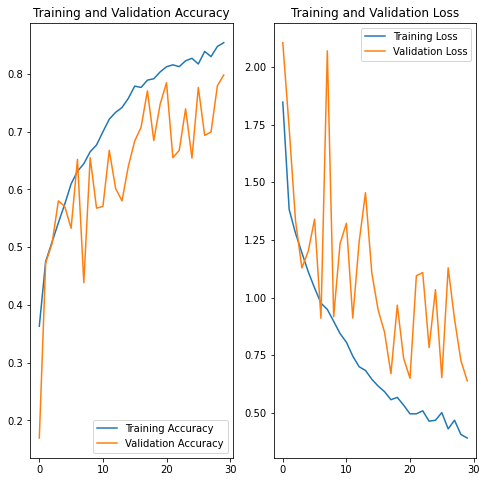

In [46]:
visualize_training_results()

#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



We see that class rebalance has helped in removing the underfitting issue. Before class rebalance the training and val accuracy was around 63 and 52% after 20 epochs. 
After doing class rebalance we have achieved a training accuracy of 85% and val accuracy of 79% . We used batch normalization and droput in our model. 

We will create one more model with some experimentation

## Final Model

In [47]:
model = Sequential([
  data_augmentation,
  normalization_layer,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [48]:
## your code goes here
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [49]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

In [50]:
## Your code goes here, use 50 epochs.
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 35s 195ms/step - loss: 1.8654 - accuracy: 0.2930 - val_loss: 1.8213 - val_accuracy: 0.3108
Epoch 2/30
169/169 [==============================] - 34s 194ms/step - loss: 1.5666 - accuracy: 0.4007 - val_loss: 1.5241 - val_accuracy: 0.4088
Epoch 3/30
169/169 [==============================] - 34s 194ms/step - loss: 1.4725 - accuracy: 0.4356 - val_loss: 1.4227 - val_accuracy: 0.4258
Epoch 4/30
169/169 [==============================] - 34s 195ms/step - loss: 1.4220 - accuracy: 0.4536 - val_loss: 1.3727 - val_accuracy: 0.4726
Epoch 5/30
169/169 [==============================] - 34s 194ms/step - loss: 1.3627 - accuracy: 0.4795 - val_loss: 1.2438 - val_accuracy: 0.5134
Epoch 6/30
169/169 [==============================] - 34s 193ms/step - loss: 1.3128 - accuracy: 0.4936 - val_loss: 1.3292 - val_accuracy: 0.5052
Epoch 7/30
169/169 [==============================] - 34s 195ms/step - loss: 1.2739 - accuracy: 0.5233 - val_loss: 1.1730 - val_ac

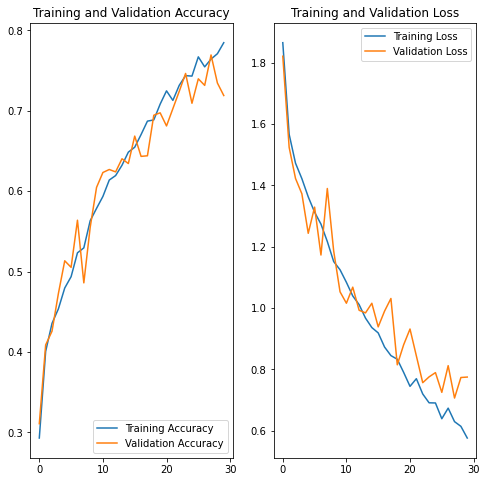

In [54]:
visualize_training_results()

**Findings:**

From the above result we come to know this model's validation accuracy is increased when compared to previous models. But this model is also overfitting.

Using class rebalance, droupout, batch normalization helps in acheiving the better result than simple model.

Accuracy can be imporved further with proper hyper-parameter. Can use different CNN Configuration, loss function, Optimizers and number of Layers and check how accuracy improves.